In [0]:
#@title Data creation
import numpy as np
n_instances = 5000 # 5,000 training instances
n_steps = 12 # 25 time steps per instance
n_channels = 4 # 4 channels per time step

# input data is of shape (n_instances, n_steps, n_channels)

def channel(t):
  c0 = 0.5 * np.sin(t) + 0.5
  c1 = 0.5 * np.sin(t / 2) + 0.5
  c2 = 0.5 * np.cos(t * 2) + 0.5
  c3 = 0.5 * np.cos(4 * t) + 0.5
  return [c0, c1, c2, c3]

data = [[channel((t * 0.001 + np.random.random()))
         for t in range(n_steps)]
        for k in range(n_instances)]

data = np.array(data).astype('float32')

In [0]:
#@title sample function
# helper function to comput z = mu + e * std
def sample(args):
  mean_, log_sig_ = args
  epsilon = K.random_normal(shape=(batch_size, n_steps, n_latent))
  return mean_ + epsilon * K.exp(log_sig_)

In [0]:
#@title imports and vars
import keras
from keras import backend as K
from keras.layers import Dense, GRU, Lambda
from keras.engine import Input
from keras.models import Model
from keras import losses, optimizers
import tensorflow as tf

K.clear_session()

n_hidden1 = 300
n_hidden2 = 500
n_latent = 1
batch_size = 200
n_epochs = 50

In [0]:
#@title encoder creation
x = Input(shape=(n_steps, n_channels,), name='inputs')

hidden1 = GRU(n_hidden1, activation='tanh',
               name='x',
               return_sequences=True,
               unroll=True)(x)
hidden2 = GRU(n_hidden2, activation='relu',
               return_sequences=True,
               unroll=True)(hidden1)
z_mean = Dense(n_latent, name='mean')(hidden2)
z_log_sigma = Dense(n_latent, name='sigma', activation='sigmoid')(hidden2)

z = Lambda(sample, name='z')([z_mean, z_log_sigma])

encoder = Model(x, z)

In [0]:
#@title decoder creation
latent_inputs = Input(shape=(n_steps, n_latent,), name='lat_in')
hidden3 = GRU(n_hidden2,
               activation='tanh',
               return_sequences=True,
               unroll=True)(latent_inputs)
hidden4 = GRU(n_hidden1,
               activation='relu',
               return_sequences=True,
               unroll=True)(hidden3)
outputs = Dense(n_channels, activation='sigmoid',
                name='outputs')(hidden4)

decoder = Model(inputs=latent_inputs, outputs=outputs)
# decoder.summary()

In [0]:
#@title end-to-end model creation
y = encoder(x)
outputs = decoder(y)

model = Model(inputs=x, outputs=outputs)

In [0]:
rec_loss = losses.mean_squared_error(x, outputs)
kl_loss = 1 - K.exp(z_log_sigma) + K.square(z_mean) + K.abs(z_log_sigma)
model.add_loss(750 * rec_loss + K.mean(K.abs(kl_loss)))

In [499]:
model.compile(optimizer='rmsprop')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Output "model_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "model_2" during training.
  """Entry point for launching an IPython kernel.


In [500]:
model.fit(x=data, epochs=20, batch_size=batch_size)

Epoch 1/20
5000/5000 [==============================] - 11s 2ms/step - loss: 43.7834
Epoch 2/20
5000/5000 [==============================] - 3s 634us/step - loss: 38.8420
Epoch 3/20
5000/5000 [==============================] - 3s 632us/step - loss: 36.7986
Epoch 4/20
5000/5000 [==============================] - 3s 632us/step - loss: 20.5918
Epoch 5/20
5000/5000 [==============================] - 3s 633us/step - loss: 14.1911
Epoch 6/20
5000/5000 [==============================] - 3s 633us/step - loss: 13.1535
Epoch 7/20
5000/5000 [==============================] - 3s 634us/step - loss: 12.5210
Epoch 8/20
5000/5000 [==============================] - 3s 633us/step - loss: 12.0802
Epoch 9/20
5000/5000 [==============================] - 3s 632us/step - loss: 12.0686
Epoch 10/20
 200/5000 [>.............................] - ETA: 3s - loss: 11.7181

5000/5000 [==============================] - 3s 634us/step - loss: 11.8929
Epoch 11/20
5000/5000 [==============================] - 3s 635us/step - loss: 11.7868
Epoch 12/20
5000/5000 [==============================] - 3s 631us/step - loss: 11.6263
Epoch 13/20
5000/5000 [==============================] - 3s 636us/step - loss: 11.6454
Epoch 14/20
5000/5000 [==============================] - 3s 638us/step - loss: 11.5044
Epoch 15/20
5000/5000 [==============================] - 3s 635us/step - loss: 11.5184
Epoch 16/20
5000/5000 [==============================] - 3s 636us/step - loss: 11.4146
Epoch 17/20
5000/5000 [==============================] - 3s 639us/step - loss: 11.3534
Epoch 18/20
5000/5000 [==============================] - 3s 638us/step - loss: 11.4196
Epoch 19/20
 400/5000 [=>............................] - ETA: 2s - loss: 11.3980

5000/5000 [==============================] - 3s 634us/step - loss: 11.3337
Epoch 20/20
5000/5000 [==============================] - 3s 634us/step - loss: 11.3787


Noise free prediction


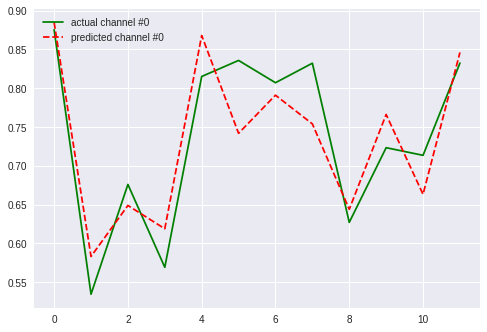

Recovery (missing data in time steps 5-25)


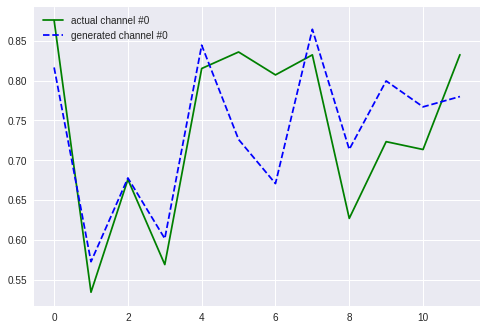

Noise free prediction


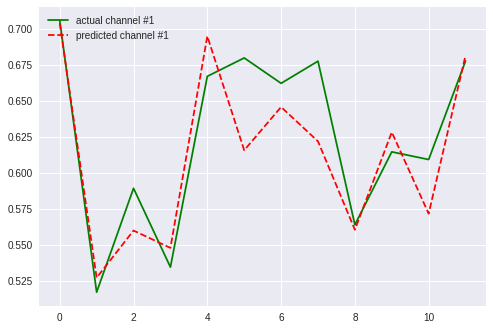

Recovery (missing data in time steps 5-25)


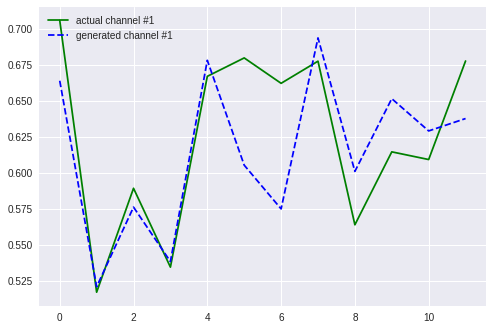

Noise free prediction


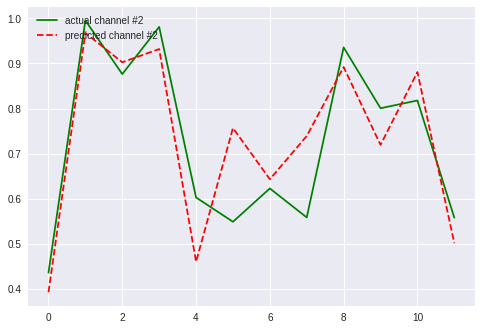

Recovery (missing data in time steps 5-25)


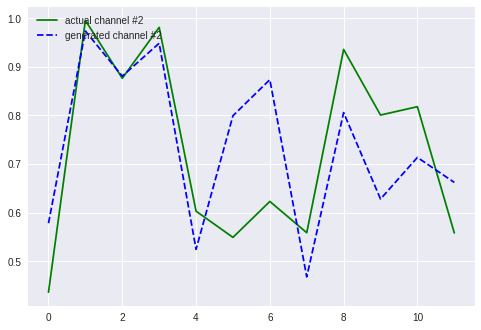

Noise free prediction


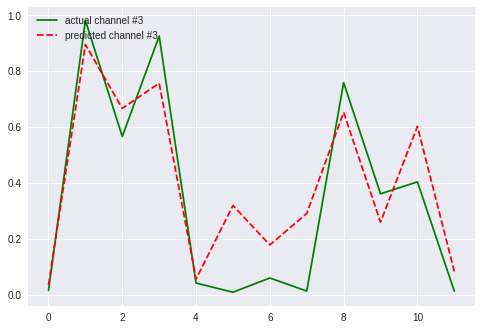

Recovery (missing data in time steps 5-25)


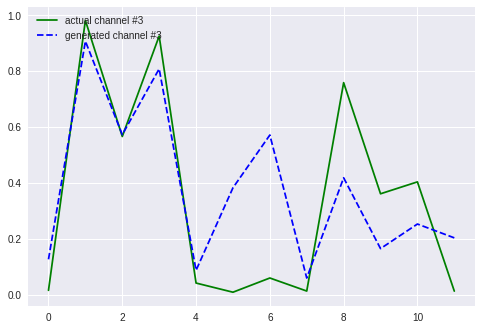

In [501]:
batch = data[:batch_size]
batch_c = np.copy(batch)

x_pred = model.predict(batch, batch_size=batch_size) # standard predictions

rand_codings = np.random.normal(size=(batch_size, n_steps, n_latent))
raw_gen = decoder.predict(rand_codings, batch_size=batch_size) # raw generation

batch_c[:, 5:25, :] = raw_gen[:, 5:25, :] # generating steps 5-25 on its own

x_gen = model.predict(batch_c,
                      batch_size=batch_size)
raw_gen = model.predict(raw_gen, batch_size=batch_size)
# shape of prediction data and batch are both (batch_size, n_steps, n_channels)
n_predictions = 1
import matplotlib.pyplot as plt
for i in range(n_predictions):
  t_1 = batch[i]
  t_2 = x_pred[i]
  t_3 = x_gen[i]
  t_4 = raw_gen[i]
  for j in range(n_channels):
    print('Noise free prediction')
    nf_true, = plt.plot(t_1[:, j], 'g', label='actual channel #' + str(j))
    nf_pred, = plt.plot(t_2[:, j], 'r--', label='predicted channel #' + str(j))
    plt.legend(handles=[nf_true, nf_pred], loc=2)
    plt.show()
    print('Recovery (missing data in time steps 5-25)')
    nf_true, = plt.plot(t_1[:, j], 'g', label='actual channel #' + str(j))
    nf_pred, = plt.plot(t_3[:, j], 'b--', label='generated channel #' + str(j))
    plt.legend(handles=[nf_true, nf_pred], loc=2)
    plt.show()